In [1]:
import pydicom as dicom
import re
import os
import numpy as np

class Patient(object):
    def __init__(self, directory, subdir):
        while True:
            subdirs = next(os.walk(directory))[1]
            if len(subdirs) == 1:
                directory = os.path.join(directory, subdirs[0])
            else:
                break
        slices = []
        for s in subdirs:
            m = re.match("sax_(\d+)", s)
            if m is not None:
                slices.append(int(m.group(1)))
        slices_map = {}
        first = True
        times = []
        for s in slices:
            files = next(os.walk(os.path.join(directory, "sax_%d" % s)))[2]
            offset = None
            for f in files:
                m = re.match("IM-(\d{4,})-(\d{4})\.dcm", f)
                if m is not None:
                    if first:
                        times.append(int(m.group(2)))
                    if offset is None:
                        offset = int(m.group(1))
            first = False
            slices_map[s] = offset
        self.directory = directory
        self.time = sorted(times)
        self.slices = sorted(slices)
        self.slices_map = slices_map
        self.name = subdir
    def _filename(self, s, t):
        fname = os.path.join(self.directory,"sax_%d" % s, "IM-%04d-%04d.dcm" % (self.slices_map[s], t))
        return fname
    def _read_dicom_image(self, filename):
        d = dicom.read_file(filename)
        img = d.pixel_array
        return np.array(img)
    def _read_all_dicom_images(self):
        f1 = self._filename(self.slices[0], self.time[0])
        f2 = self._filename(self.slices[1], self.time[0])
        d1 = dicom.read_file(f1)
        d2 = dicom.read_file(f2)
        (x, y) = d1.PixelSpacing
        (x, y) = (float(x), float(y))
        self.col_scaling = x
        self.row_scaling = y
        try:
            dist = np.abs(d2.SliceLocation - d1.SliceLocation)
        except AttributeError:
            try:
                dist = d1.SliceThickness
            except AttributeError:
                dist = 6
                
        self.images = np.array([[self._read_dicom_image(self._filename(d, i))for i in self.time]for d in self.slices])
        self.dist = dist
        self.deph_mm = self.dist * (self.images.shape[0] - 1)
        self.area_multiplier = x * y
        self.orientation = d1.ImageOrientationPatient
        
    def load(self):
        self._read_all_dicom_images()

In [2]:
#LOAD DATA
def load_patient(patient_id, root_dir=None):
    if not root_dir: 
        root_dir =  os.path.join('..', 'Downloads', 'train', 'train')
    patient_id = str(patient_id)
    base_path = os.path.join(root_dir, patient_id)
    try:
        tdata = Patient(base_path, patient_id)
        tdata.load()
        if len(tdata.images.shape) == 4:
            return tdata
    except (ValueError, TypeError, IndexError, AttributeError, FileNotFoundError):
        print('Patient %s could not be loaded.' % patient_id)
        return None
    
def load_multiple_patients(patient_ids=False, root_dir=None, verbose=False):
    if not patient_ids:
        patient_ids = range(1, 251)
    patient_list = []
    for pid in patient_ids:
        if verbose:
            print('Loading patient %i...' % pid)
        p_data = load_patient(pid, root_dir=root_dir)
        if p_data:
            patient_list.append(p_data)
    return patient_list

In [3]:
#FOURIERTRANSFRM
import numpy as np
def fourier_time_transform_slice(image_3d):
    fft_img_2d = np.fft.fftn(image_3d)[1, :, :]
    return np.abs(np.fft.ifftn(fft_img_2d))

def fourier_time_transform(patient_images):
    ftt_image = np.array([
        fourier_time_transform_slice(patient_slice)
        for patient_slice in patient_images
    ])
    return ftt_image

In [4]:
#SEGMENTATION
import numpy as np
from skimage.morphology import binary_dilation, binary_erosion, binary_opening, binary_closing, disk
from skimage.filters import threshold_otsu

def thresh_segmentation(patient_img):
    thresh = threshold_otsu(patient_img)
    binary = patient_img > thresh
    return binary
def segment_multiple(patient_img):
    num_slices, height, width = patient_img.shape
    segmented_slices = np.zeros((num_slices, height, width))
    for i in range(num_slices):
        seg_slice = thresh_segmentation(patient_img[i])
        if seg_slice.sum() > seg_slice.size * 0.5:
            seg_slice = 1 - seg_slice
        segmented_slices[i] = seg_slice
    return segmented_slices
def roi_mean_yx(patient_img):
    seg_slices = segment_multiple(patient_img)
    num_slices = seg_slices.shape[0]
    y_all, x_all = np.zeros(num_slices), np.zeros(num_slices)
    neighborhood = disk(2)
    for i,seg_slice in enumerate(seg_slices):
        seg_slices_eroded = binary_erosion(seg_slice, neighborhood) 
        y_coord, x_coord = seg_slices_eroded.nonzero()
        y_all[i], x_all[i] = np.mean(y_coord), np.mean(x_coord)
    mean_y = int(np.mean(y_all))
    mean_x = int(np.mean(x_all))
    return mean_y, mean_x

In [5]:
from skimage import exposure

def histogram_normalize_4d(images, clip_limit=0.03):
    slices, time, _, _ = images.shape
    norm_imgs_4d = np.empty(images.shape)
    for i in range(slices):
        for j in range(time):
            norm_imgs_4d[i,j] = exposure.equalize_adapthist(images[i,j].astype(np.uint16), clip_limit=clip_limit)
    return norm_imgs_4d

In [6]:
#RESCALING
import cv2

def rescale_patient_4d_imgs(patient, img_4d):
    if len(img_4d.shape) < 4: raise Exception("Patient images are not 4D!")
    num_slices, time, _, _ = img_4d.shape
    fx, fy = patient.col_scaling, patient.row_scaling
    example_img = cv2.resize(src=img_4d[0,0], dsize=None, fx=fx, fy=fy)
    scaled_height, scaled_width = example_img.shape
    scaled_imgs = np.zeros((num_slices, time, scaled_height, scaled_width))
    
    for i in range(num_slices):
        for j in range(time):
            scaled_imgs[i,j] = cv2.resize(src=img_4d[i,j], dsize=None, fx=fx, fy=fy)
    return scaled_imgs

def crop_roi(img, dim_y, dim_x, cy, cx):
    cy, cx = int(round(cy)), int(round(cx))
    h, w = img.shape
    if dim_x > w or dim_y > h: raise ValueError('Crop dimensions larger than image dimension!')
    new_img = np.zeros((dim_y, dim_x))
    dx, dy = int(dim_x / 2), int(dim_y / 2)
    dx_odd, dy_odd = int(dim_x % 2 == 1), int(dim_y % 2 == 1)
    dx_left = max(0, cx - dx)
    dx_right = min(w, cx + dx + dx_odd)
    dy_up = max(0, cy - dy)
    dy_down = min(h, cy + dy + dy_odd)
    range_x = dx_right - dx_left
    range_y = dy_down - dy_up
    new_img[0:range_y, 0:range_x] = img[dy_up:dy_down, dx_left:dx_right]
    return new_img

def crop_heart(images_4d, heart_pixel_size=200):
    # Find center for cropping
    ft_imges = fourier_time_transform(images_4d)
    y, x = roi_mean_yx(ft_imges)
    num_slices, time, h, w = images_4d.shape
    heart_cropped_img_4d = np.zeros((num_slices, time, heart_pixel_size, heart_pixel_size))  
    for i in range(num_slices):
        for j in range(time):
            heart_cropped_img_4d[i,j] = crop_roi(images_4d[i,j], heart_pixel_size, heart_pixel_size, y, x)
    return heart_cropped_img_4d

def rotate_images_210_deg(images_4d, orientation):
    angle = np.arctan2(orientation[:3], orientation[:3]) / np.pi * 180 - 75
    rotation_needed = angle[2] > (-210)
    if rotation_needed:
        slices, time, _, _ = images_4d.shape
        rot_width, rot_height = np.rot90(images_4d[0,0], k=1).shape
        rot_images = np.zeros((slices, time, rot_width, rot_height))
        for i in range(slices):
            for j in range(time):
                rot_images[i,j] = np.rot90(images_4d[i,j], k=1)
        return rot_images
    return images_4d

In [7]:
#PREPROCESSIONG
def take_middle_slice(images_4d, expand_dims=True):
    middle = int(images_4d.shape[0] / 2)
    images_3d = images_4d[middle]
    if expand_dims:
        images_3d = np.expand_dims(images_3d, axis=0)
    return images_3d

def resize_4d_img(image_4d, img_size):
    n_slices, n_time = image_4d.shape[0], image_4d.shape[1]
    resized_imgs = []
    for img_3d in image_4d:
        resized_3d = []
        for img_2d in img_3d:
            resized_2d = imresize(img_2d, (img_size, img_size))
            resized_3d.append(resized_2d)
        resized_imgs.append(resized_3d)
    return np.array(resized_imgs)

def preprocess_pipeline(patient, heart_pixel_size=180):
    middle_slice_3d_images = take_middle_slice(patient.images)
    rescaled_imgs = rescale_patient_4d_imgs(patient, middle_slice_3d_images)
    normalized_imgs = histogram_normalize_4d(rescaled_imgs)
    cropped_imgs = crop_heart(normalized_imgs, heart_pixel_size=heart_pixel_size)
    rotated_images = rotate_images_210_deg(cropped_imgs, patient.orientation)
    return rotated_images.astype(np.float16)

In [8]:
#PLOTTING
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import montage as montage2d

montage3d = lambda x, **k: montage2d(np.stack([montage2d(y, **k) for y in x], 0))

def plot_patient_slices_3d(patient_slices, title=False, figsize=(20, 20)):
    patient_slices = patient_slices.astype(np.float64)
    '''Plots a 2D image per slice in series (3D in total)'''
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    image = montage2d(patient_slices)
    if title: ax.set_title(title)
    ax.imshow(image, cmap='bone')


def plot_patient_data_4d(patient_data, all_slices=False, num_slices=[0], figsize=(20, 20)):
    patient_data = patient_data.astype(np.float64)
    '''Plots a 3D image per time step in patient data (4D in total)'''
    if all_slices:
        num_slices = range(patient_data.shape[0])
    for i in num_slices:
        plot_patient_slices_3d(patient_data[i],title=('Showing slice %i' % i))

In [9]:
path=r'C:/Users/yakub/Downloads/train/train'
train_dir = os.path.normpath(path)

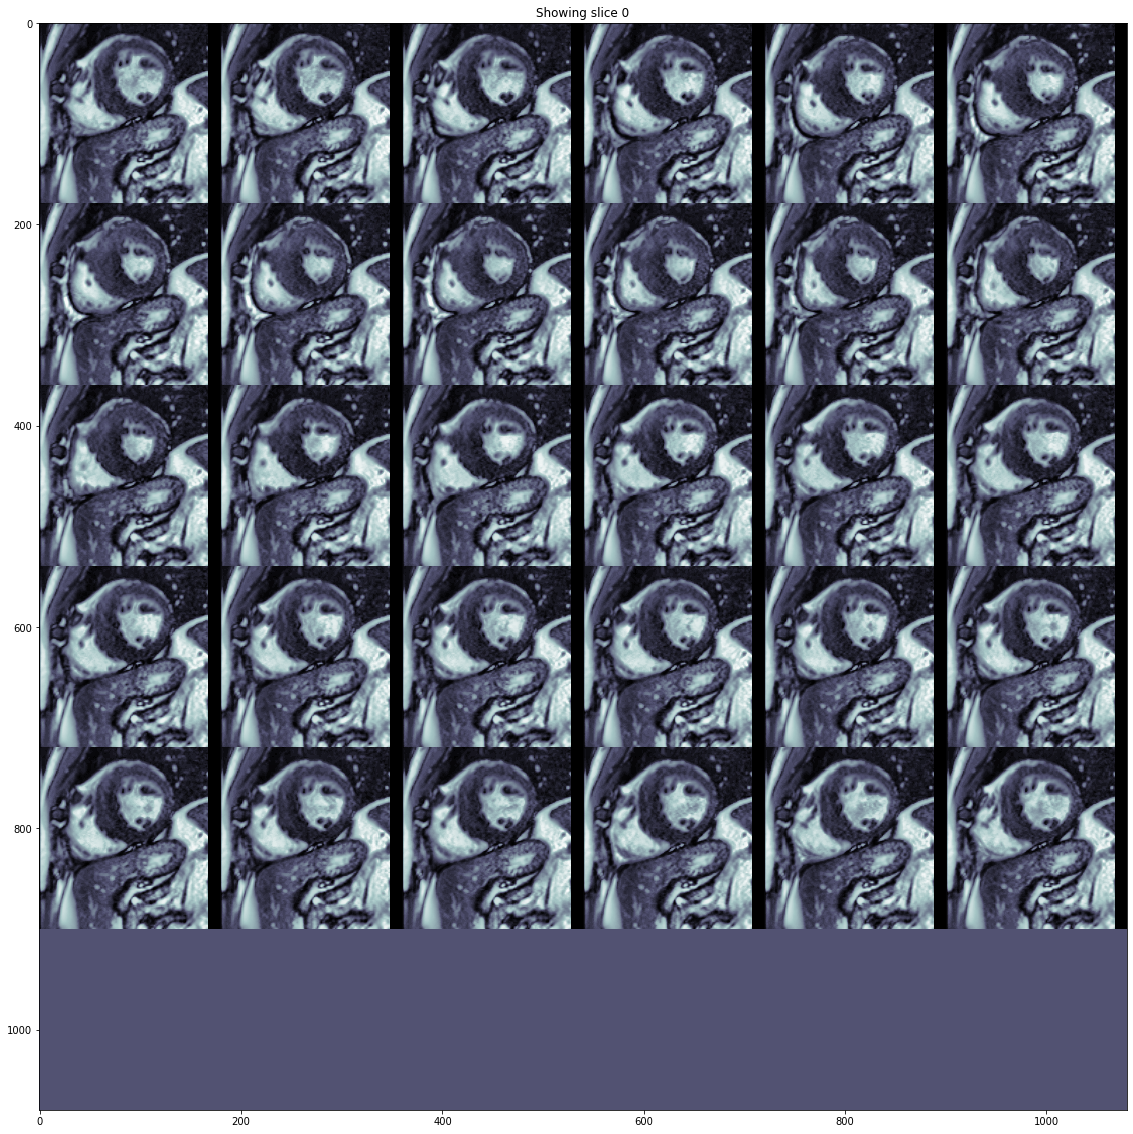

In [10]:
test_patient = load_patient(30, train_dir)
processed_imgs = preprocess_pipeline(test_patient)
plot_patient_data_4d(processed_imgs)